In [14]:
import seaborn as sn
import quandl
API_KEY = "yCev-u-joPYss-FULGkt"
quandl.ApiConfig.api_key = (API_KEY)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [15]:
from sklearn.metrics import  mean_squared_error
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [16]:
def forecast_accuracy(forecast, actual):
    mse = mean_squared_error(actual, forecast)
    return math.sqrt(mse)

Let's retrieve the data

In [17]:
heartCare_df = quandl.get('HKEX/06609')
print(heartCare_df.shape)
heartCare_df.info()

(405, 12)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 405 entries, 2021-08-20 to 2023-04-18
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Nominal Price       405 non-null    float64
 1   Net Change          0 non-null      object 
 2   Change (%)          0 non-null      object 
 3   Bid                 405 non-null    float64
 4   Ask                 405 non-null    float64
 5   P/E(x)              0 non-null      object 
 6   High                405 non-null    float64
 7   Low                 405 non-null    float64
 8   Previous Close      404 non-null    float64
 9   Share Volume (000)  405 non-null    float64
 10  Turnover (000)      405 non-null    float64
 11  Lot Size            0 non-null      object 
dtypes: float64(8), object(4)
memory usage: 41.1+ KB


In [18]:
df = pd.DataFrame({'Date': heartCare_df.index.values,
                    'value': heartCare_df['Nominal Price']
                          })
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    405 non-null    datetime64[ns]
 1   value   405 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.5 KB
None


Let's try to predict the Nominal Price with time series

# ARIMA

ADF Test for Null Hypothesis

In [19]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.643014
p-value: 0.084429


p-value > 0.05 => Null hypothesis is not true.
Now, to find 'd'

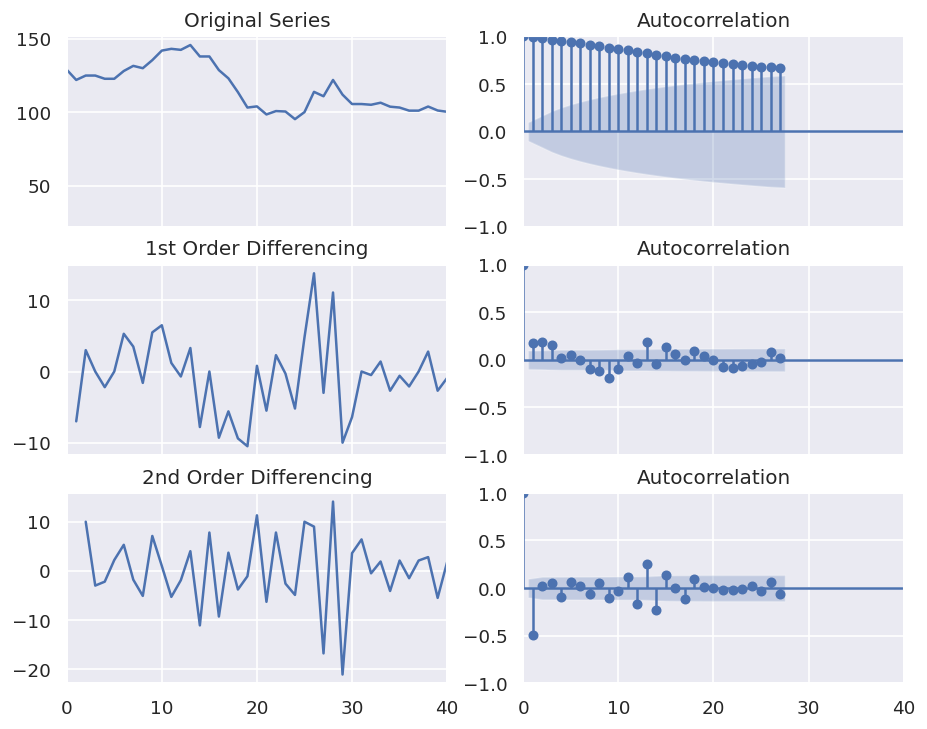

In [20]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
axes[0, 1].set_xlim([0, 40])
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 1].set_xlim([0, 40])
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

d = 1

Now , lets find q

/home/ananthNB/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


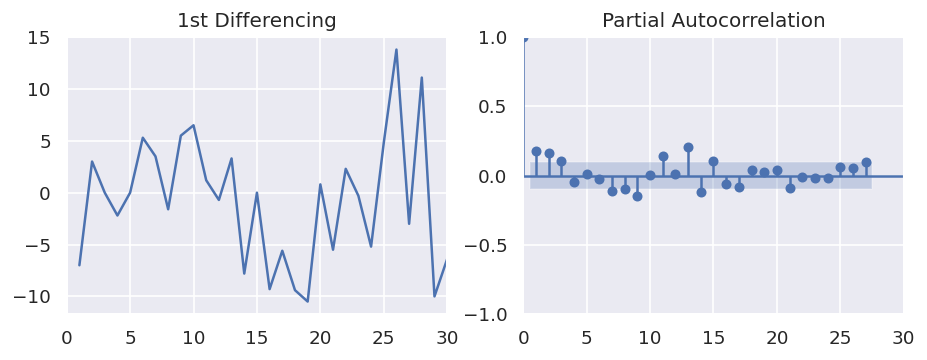

In [21]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,4))
axes[1].set_xlim([0, 30])
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

p = 1, Now lets find p

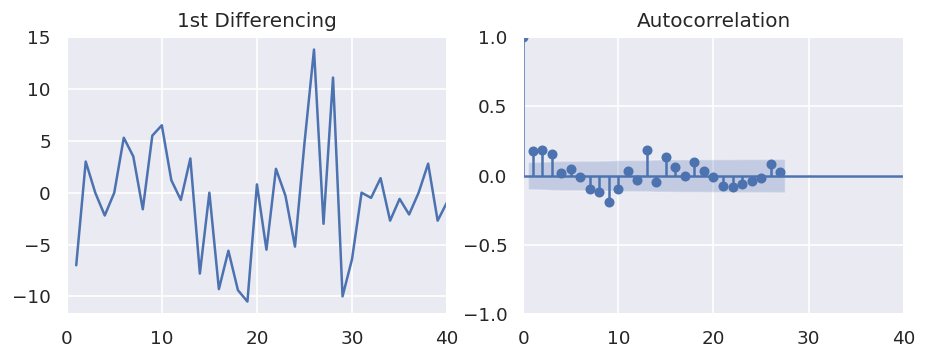

In [22]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

q = 1, Now let's create the model

In [23]:
from statsmodels.tsa.arima.model import ARIMA
train = df[:350]
test = df[350:]
# 1,3,3 ARIMA Model
model = ARIMA(train.value, order=(1,1,1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  350
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -801.301
Date:                Wed, 19 Apr 2023   AIC                           1608.601
Time:                        01:46:36   BIC                           1620.167
Sample:                             0   HQIC                          1613.205
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6997      0.085      8.190      0.000       0.532       0.867
ma.L1         -0.5147      0.100     -5.164      0.000      -0.710      -0.319
sigma2         5.7768      0.217     26.662      0.0

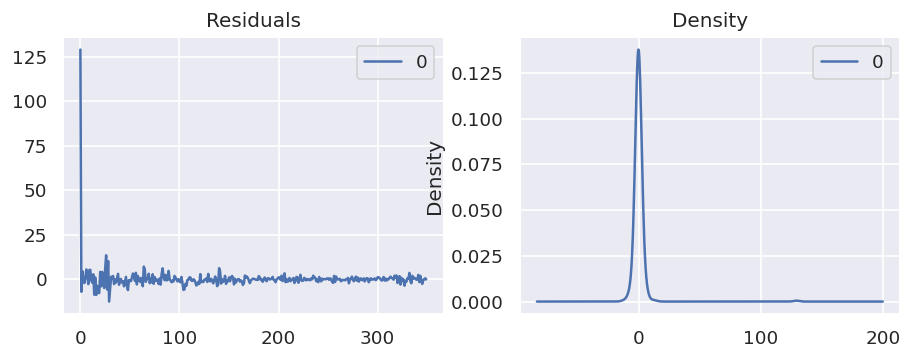

In [24]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

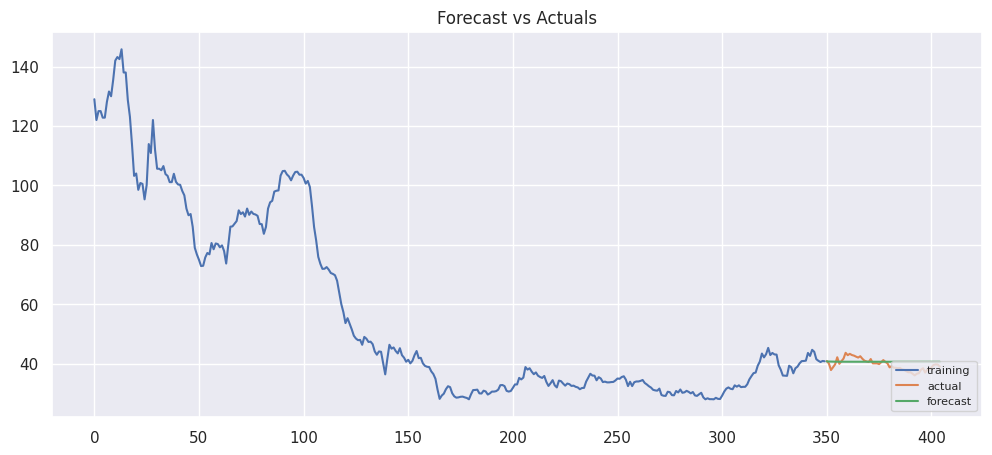

In [25]:
#Forecast
forecast = fitted.predict(start=350, end=404)
# print(forecast)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='training')
plt.plot(test.value, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='lower right', fontsize=8)
plt.show()

Root Mean Squared Error (MSE)

In [26]:
print(forecast_accuracy(forecast,test.value))
# test.value

2.1265619073927278
